In [2]:
"""
GSoC 2025 Internship Application Task - 2
Author: Dhruv Srivastava
"""

"""Import dependencies"""
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import glob
from torchvision.models import resnet18

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/gsoc_2025/common_test_2/

Mounted at /content/drive
/content/drive/My Drive/gsoc_2025/common_test_2


In [ ]:
"""Define custom dataset for lensing images"""
class MyDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        self.transform = transform

        # Collect lens and non-lens image paths
        self.lens_paths = glob.glob(os.path.join(lens_dir, '*.npy'))
        self.nonlens_paths = glob.glob(os.path.join(nonlens_dir, '*.npy'))

        # Combine paths and create labels
        self.all_paths = self.lens_paths + self.nonlens_paths
        self.labels = [1] * len(self.lens_paths) + [0] * len(self.nonlens_paths)

        print(f"Loaded {len(self.lens_paths)} lens images and {len(self.nonlens_paths)} non-lens images")

    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, idx):
        # Load the image data (3, 64, 64)
        img_path = self.all_paths[idx]
        image = np.load(img_path)

        # Convert to torch tensor (already in the format (channels, height, width))
        image = torch.tensor(image, dtype=torch.float32)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Get the label
        label = self.labels[idx]

        return image, label


In [ ]:
"""Load datasets into torch"""
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_lenses_dir = 'lens-finding-test/train_lenses'
train_nonlenses_dir = 'lens-finding-test/train_nonlenses'
test_lenses_dir = 'lens-finding-test/test_lenses'
test_nonlenses_dir = 'lens-finding-test/test_nonlenses'

# Create datasets
train_dataset = MyDataset(train_lenses_dir, train_nonlenses_dir, transform=transform)
test_dataset = MyDataset(test_lenses_dir, test_nonlenses_dir, transform=transform)

# Calculate class weights to handle imbalance
total_samples = len(train_dataset)
lens_count = sum(train_dataset.labels)
nonlens_count = total_samples - lens_count

# Weights inversely proportional to class frequencies
lens_weight = total_samples / (2 * lens_count)
nonlens_weight = total_samples / (2 * nonlens_count)
class_weights = torch.tensor([nonlens_weight, lens_weight], dtype=torch.float32)

print(f"Class weights - Non-lens: {nonlens_weight:.4f}, Lens: {lens_weight:.4f}")

# Create data loaders with weighted sampling for training
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=[class_weights[label] for label in train_dataset.labels],
    num_samples=len(train_dataset),
    replacement=True
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loaded 1730 lens images and 28675 non-lens images
Loaded 195 lens images and 19455 non-lens images
Class weights - Non-lens: 0.5302, Lens: 8.7876


In [6]:
"""
Define model. Try using a modified ResNet18 architecture.
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Use a pre-trained ResNet18 model
        self.resnet = resnet18(pretrained=True)

        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.resnet(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

C:\Users\dhruv12\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dhruv12\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dhruv12/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [ ]:
"""Model training function"""
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    history = {'train_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        batch_count = 0

        for inputs, labels in train_loader:
            print(f"Processing batch {batch_count+1}")
            print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")
            print(f"Input min/max: {inputs.min().item()}/{inputs.max().item()}")

            # Check for NaN values
            if torch.isnan(inputs).any():
              print("Warning: NaN values in inputs")
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            print(f"Batch loss: {loss.item()}")

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            batch_count += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        #Debug print
        print("Epoch loss: ", epoch_loss)
        history['train_loss'].append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return history

In [9]:
"""Model evaluation function"""
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()

            all_labels.extend(labels.numpy())
            all_probs.extend(probs)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


Processing batch 1
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104904175
Batch loss: 0.7061188220977783
Processing batch 2
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104904175
Batch loss: 0.6898006200790405
Processing batch 3
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104904175
Batch loss: 0.5627692937850952
Processing batch 4
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104904175
Batch loss: 0.5627198219299316
Processing batch 5
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104904175
Batch loss: 0.6053203344345093
Processing batch 6
Input shape: torch.Size([32, 3, 64, 64]), Labels shape: torch.Size([32])
Input min/max: -2.1179039478302/2.640000104

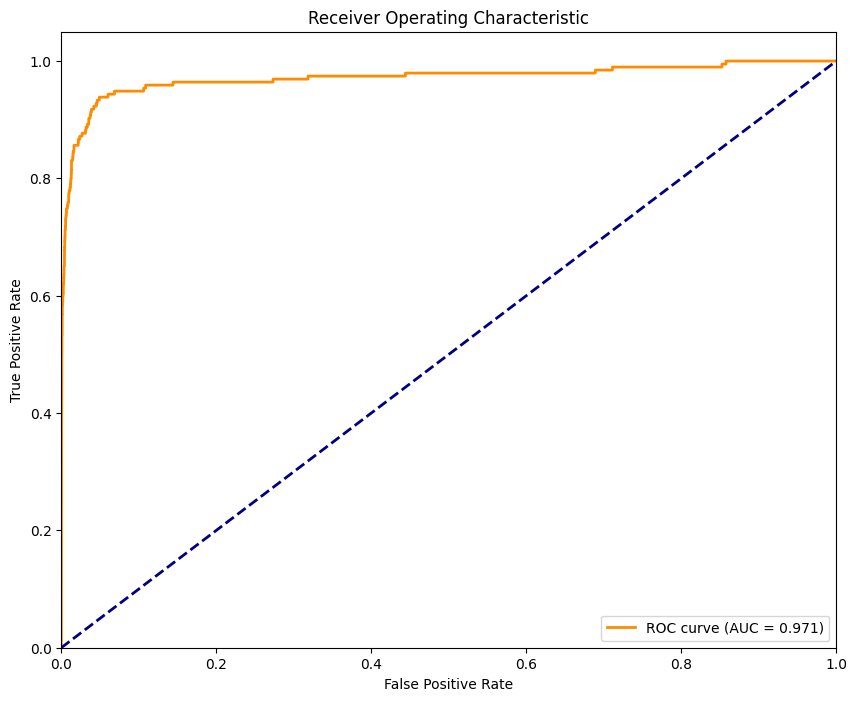

In [ ]:
"""Finally, train the model"""
num_epochs = 15
history = train_model(model, train_loader, criterion, optimizer, device, num_epochs)

# Evaluate the model
fpr, tpr, roc_auc = evaluate_model(model, test_loader, device)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Save the model
torch.save(model.state_dict(), 'lens_id.pth')


In [ ]:
def predict_lens(model, image_path, device, transform):
    # Load image
    image = np.load(image_path)
    image_tensor = torch.tensor(image, dtype=torch.float32)

    if transform:
        image_tensor = transform(image_tensor)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.sigmoid(output).item()

    return probability
